# plotting the sun's polar field with python + d3

In this notebook, we will be plotting the average magnetic field around the solar poles to determine when, exactly, the Sun's polar field flips. We'll use data from the Helioseismic and Magnetic Imager instrument on NASA's Solar Dynamics Observatory (SDO) satellite, which takes about 1.5 terabytes of data a day (more data than any satellite in NASA history). We'll grab the data from the <a  href="http://jsoc.stanford.edu/ajax/lookdata.html">JSOC database</a> via a JSON API and plot it using <a  href="https://mpld3.github.io/">mpld3</a>, a python interface for <a  href="http://d3js.org/">d3</a>. 

In [1]:
import json, urllib, numpy as np, matplotlib.pylab as plt, matplotlib.ticker as mtick, mpld3
from mpld3 import plugins
from datetime import datetime as dt_obj
from matplotlib.dates import *
%matplotlib inline
%config InlineBackend.figure_format='retina'
mpld3.enable_notebook()

Now we'll execute a sample JSON query using the json and urllib modules to gather the data -- specifically, two keywords that hold the value of the mean radial component of the magnetic field in the polar region (greater than 60 degrees latitude). In theory, it is possible to parse JSON queries using the <code>read_json()</code> function in the pandas library, but, in practice, the object returned by the JSON API for the SDO database, <code>jsoc_info</code>, isn't formatted in a way that <code>pandas.read_json()</code> can understand easily.

In [2]:
# first get the most recent timestamp, or t_rec
url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.meanpf_720s[$]&op=rs_list&key=T_REC"
response = urllib.urlopen(url)
data = json.loads(response.read())
t_last = data['keywords'][0]['values'][0]

# now gather all the data between SDO launch and the most recent t_rec
url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.meanpf_720s[2010.05.01_00_TAI-"+t_last+"@1d]&op=rs_list&key=T_REC,CAPN2,CAPS2"
response = urllib.urlopen(url)
data = json.loads(response.read())

Now we'll create some empty lists to hold the data:

In [3]:
capn2 = [] # this holds the keyword CAPN2 (Mean radial field in N60-N90) 
caps2 = [] # this holds the keyword CAPS2 (Mean radial field in S60-S90)
t_rec  = [] # this holds the keyword T_REC

<code>data</code> is of type dict, so we'll get the number of keyword elements this way:

In [4]:
n_elements = len(data['keywords'][1]['values'])

And then we'll populate our empty lists to hold the keyword values:

In [5]:
for i in range(n_elements):
    capn2.append(float(data['keywords'][1]['values'][i]))

for i in range(n_elements):
    caps2.append(float(data['keywords'][2]['values'][i]))

for i in range(n_elements):
    t_rec.append(data['keywords'][0]['values'][i])

Let's convert our lists to numpy arrays, because they're easier to work with:

In [6]:
capn2 = np.array(capn2)
caps2 = np.array(caps2)
t_rec  = np.array(t_rec,dtype='S16') # this dtype is ok to set as the format of T_REC will never change

The error in the value of CAPN2 and CAPS2 at any point in time is defined by the standard deviation in this quantity over a 30 day period (beginning 15 days before the time of interest and ending 15 days after the time of interest):

In [7]:
err_capn2 = np.zeros(n_elements)
err_caps2 = np.zeros(n_elements)

for i in range(15,n_elements-16):
    err_capn2[i] = np.std(capn2[i-15:i+15])
    
for i in range(15,n_elements-16):
    err_caps2[i] = np.std(caps2[i-15:i+15])

T_REC is formatted in a way that matplotlib.pyplot will not understand, so let's convert the numpy array into a datetime object:

In [8]:
def parse_tai_string(tstr,datetime=True):
    year   = int(tstr[:4])
    month  = int(tstr[5:7])
    day    = int(tstr[8:10])
    hour   = int(tstr[11:13])
    minute = int(tstr[14:16])
    if datetime: return dt_obj(year,month,day,hour,minute)
    else: return year,month,day,hour,minute

x = np.array([parse_tai_string(t_rec[i],datetime=True) for i in range(t_rec.size)])

Now for some interactive plotting with `mpld3`! The home, pan, and zoom buttons on the lower left-hand corner of the plot allow you to explore the data.<br>
To throw the plot below up on a webpage, simply print the html by calling the `mpld3` function `fig_to_html()`.

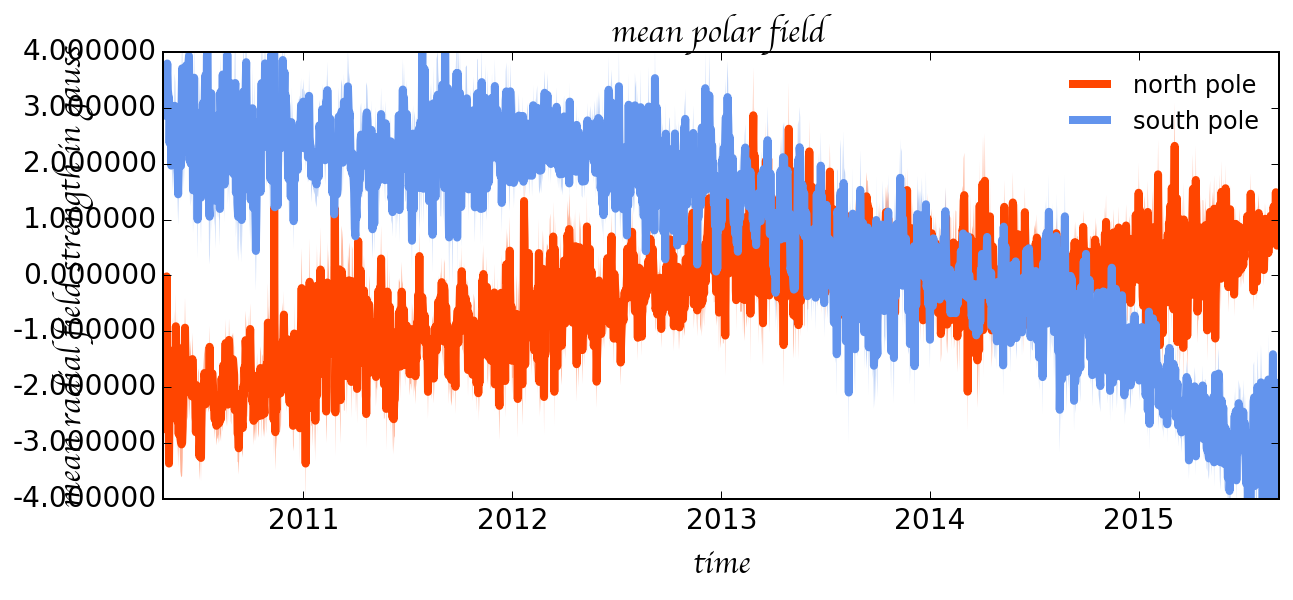

In [9]:
fig, ax = plt.subplots(figsize=(10,8))      # define the size of the figure
orangered = (1.0,0.27,0,1.0)                # create an orange-red color
cornblue  = (0.39,0.58,0.93,1.0)            # create an cornflower blue color

# define some style elements
marker_style = dict(linestyle='-', linewidth=4, fillstyle='full',color=orangered,markeredgecolor=orangered)
marker_style2 = dict(linestyle='-', linewidth=4, fillstyle='full',color=cornblue,markeredgecolor=cornblue)
text_style = {'family' : 'cursive','color'  : 'black','weight' : 'normal','size'   : 16}
#text_style = dict(fontsize=16, fontdict={'family': 'georgia'})

ax.tick_params(labelsize=14)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%1f'))

# ascribe the data to the axes
ax.plot(x, capn2, label='north pole', **marker_style)
ax.plot(x, caps2, label='south pole', **marker_style2)
ax.set_ylim([-4,4])

# add the error bars
ax.fill_between(x, capn2-err_capn2, capn2+err_capn2, facecolor=orangered, edgecolor='None', alpha=0.4, interpolate=True)
ax.fill_between(x, caps2-err_caps2, caps2+err_caps2, facecolor=cornblue, edgecolor='None', alpha=0.4, interpolate=True)

# format the x-axis with universal time
locator = AutoDateLocator()
locator.intervald[DAILY] = [1] # only show every year
formatter = DateFormatter('%Y')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# label the axes and the plot
ax.set_xlabel('time', fontdict = text_style)
ax.set_ylabel('mean radial field strength in gauss', fontdict=text_style, labelpad = -40)
ax.set_title('mean polar field', fontdict = text_style) # annotate the plot with a start time
fig.set_size_inches(10,4)
legend = plt.legend(loc='upper right', fontsize=12, framealpha=0.0,title='')
legend.get_frame().set_linewidth(0.0)